In [34]:
import xarray as xr
import pandas as pd
import numpy as np
from os.path import join, isfile
# from hwtmode.data import load_labels
from sklearn.metrics import confusion_matrix, roc_auc_score, brier_score_loss, accuracy_score
from sklearn.calibration import calibration_curve

import matplotlib
import matplotlib.pyplot as plt

In [35]:
def load_labels(start, end, label_path, run_freq, file_format):
    labels = []
    for run_date in pd.date_range(start, end, freq=run_freq[0], closed="left"):
        file_name = join(label_path, f'track_step_NCARSTORM_d01_{run_date.strftime("%Y%m%d-0000")}.{file_format}')
        
        if isfile(file_name):
            if file_format == 'parquet':
                labels.append(pd.read_parquet(file_name))
            elif file_format == 'csv':
                labels.append(pd.read_csv(file_name))
        else:
            continue

    return pd.concat(labels)

In [36]:
labels = load_labels("2013-01-01", "2013-12-31", "/glade/campaign/mmm/parc/sobash/mode_objects_hwt/track_data_ncarstorm_3km_REFL_COM_hyst_csv", "daily", "csv") # all storms in WRF dataset

cnn_training_data = pd.read_csv('/glade/work/sobash/HWT_mode/model_cnn_test2_addstorms2_noaugval_newtrain/predictions_train.csv') # all storms in hand labeled dataset
cnn_test_data = pd.read_csv('/glade/work/sobash/HWT_mode/model_cnn_test2_addstorms2_noaugval_newtrain/predictions_test.csv')

cnn_training_data = cnn_training_data.iloc[:1781] #only get first set of storms (rest are rotated)
hand_labeled = pd.concat([cnn_training_data, cnn_test_data])
#hand_labeled = hand_labeled.loc[hand_labeled['run_date'] >= "2013-01-01"]

# create columns with int and names
categories_int = {'Q1':0, 'Q2':0, 'S1':1, 'S2':0, 'S3':1, 'D1':2, 'D2':2}
categories = {'Q1':'QLCS', 'Q2': 'QLCS', 'S1':'Supercell', 'S2':'QLCS', 'S3':'Supercell', 'D1':'Disorganized', 'D2':'Disorganized'}

hand_labeled['new_label_int'] = hand_labeled['label'].apply(lambda x: categories_int[x])
hand_labeled['new_label'] = hand_labeled['label'].apply(lambda x: categories[x])

# create unique id for both datasets
hand_labeled['unique_id'] = hand_labeled['run_date'].astype(str) + '.' + hand_labeled['track_id'].astype(str) + '.' + hand_labeled['track_step'].astype(str)
labels['unique_id'] = labels['Run_Date'].astype(str).apply(lambda x: x[:10]) + '.' + labels['Track_ID'].apply(lambda x: str(x[-3:]).lstrip("0")) + '.' + labels['Duration'].astype(str)

# create matched storms dataframe
matched_labels = labels[labels['unique_id'].isin(hand_labeled.loc[:, 'unique_id'])] #extract only the storms with hand labels

# create five label columns in matched_labels dataframe
matched_labels.loc[:, 'true_label'] = hand_labeled.loc[:, 'new_label'].values.copy()
matched_labels.loc[:, 'true_label_int'] = hand_labeled.loc[:, 'new_label_int'].values.copy()
modes = ['QLCS', 'Supercell', 'Disorganized']
for mode in modes: matched_labels.loc[:, f'true_label_{mode}_int'] = np.where(matched_labels[f'true_label'] == mode, 1.0, 0.0)

# prevent probs larger than 1
prob_cols = [col for col in matched_labels.columns if 'prob' in col]
matched_labels.loc[:, prob_cols] = np.where(matched_labels[prob_cols] > 1, 1, matched_labels[prob_cols])

/glade/work/sobash/conda-envs/tf2py37/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


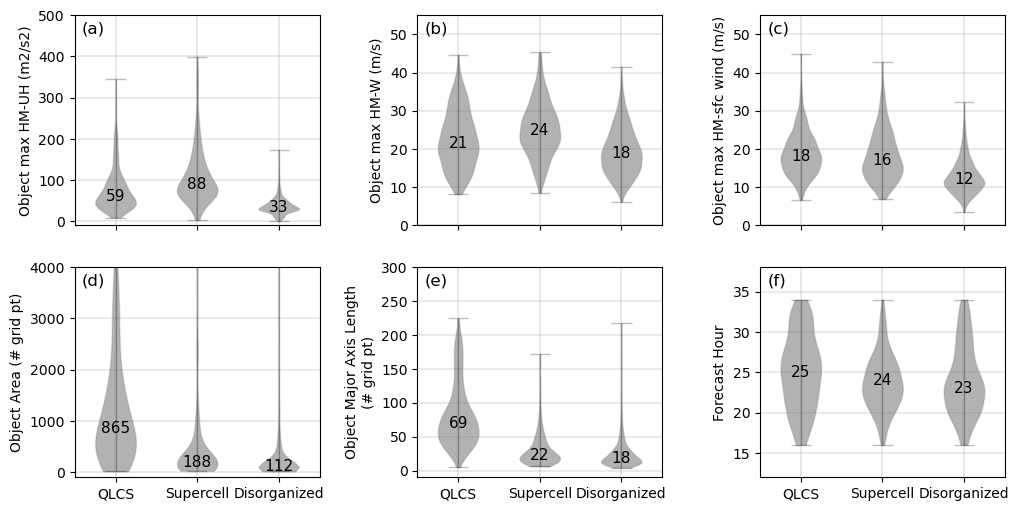

In [41]:
fig, axes = plt.subplots(2, 3, sharex='col', figsize=(12,6))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.2,wspace=0.4)

# loop through each panel
panels = ['a', 'b', 'c', 'd', 'e', 'f']
limits = [(-10,500), (0,55), (0,55), (-100,4000), (-10,300), (12,38) ]
variable_names = ['UP_HELI_MAX_max', 'W_UP_MAX_max', 'WSPD10MAX_max', 'area', 'major_axis_length', 'Forecast_Hour']
field_names = ['Object max HM-UH (m2/s2)', 'Object max HM-W (m/s)', 'Object max HM-sfc wind (m/s)', 'Object Area (# grid pt)', 'Object Major Axis Length\n(# grid pt)', 'Forecast Hour']

for k, field in enumerate(variable_names):
    ax1 = axes[k]

    # adjust axes labels/ticks/etc
    ax1.set_xlim((0.5,3.5))
    ax1.set_xticks([1,2,3] )
    ax1.set_xticklabels(modes)
    ax1.set_ylim(limits[k])
    ax1.grid(linewidth=0.25, color='gray')

    ax1.set_ylabel('%s'%(field_names[k]))

    flierprops = dict(marker='o', markerfacecolor='0.6', markersize=2.5, markeredgecolor='0.6')
    medianprops = dict(color='k', linewidth=1.5)
    boxprops = dict(linestyle='-', linewidth=0, facecolor='gray')

    boxplot_data =[]
    for n,mode in enumerate(modes):
        mask = (matched_labels[f'true_label_%s_int'%mode]==1).values
        boxplot_data.append( matched_labels[field][mask] )
        avg = matched_labels[field][mask].median()
        ax1.text(n+1, avg, '%d'%avg, ha='center', va='center', fontsize=11)
        #print(matched_labels[field][mask].max())
        
    ax1.text(0.03, 0.97, '(%s)'%panels[k], transform=ax1.transAxes, va='top', ha='left', fontsize=12)

    #ax1.boxplot(boxplot_data, positions=[1,2,3], widths=0.25, manage_ticks=False, patch_artist=True, \
                #boxprops=boxprops, medianprops=medianprops, flierprops=flierprops)
    parts = ax1.violinplot(boxplot_data, positions=[1,2,3], widths=0.5, showextrema=True)

    for pc in [parts.get(key) for key in ['cmaxes', 'cbars', 'cmins']]:
        pc.set_linewidth(1)
        pc.set_color('k')
        pc.set_alpha(0.25)

    for pc in parts['bodies']:
        pc.set_facecolor('k')
        pc.set_edgecolor('0.5')
        pc.set_alpha(0.3)

#plt.savefig('labeled_storms_stats.png', bbox_inches='tight')